In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.svm import SVR

from xgboost.sklearn import XGBRegressor

from src.visuals import *
from src.feature_engineering import *

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [97]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)
data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


# Data exploration

All 28 variables in the dataset are continuous, except for "date", which has been set as the index.

The dataset contains:
* General appliances' energy usage (Appliances)
* Lights' energy usage (Lights)
* Temperature and relative humidity in 8 rooms: kitchen, living room, office room, bathroom, two beedrooms, laundry room and ironing room, labeled as T1, Rh_1...T9, Rh_9 (excluding T6, RH_6 which represent temperature and humidity outside the house)
* Temperature and relative humidity outside the house (as mentioned above, and also from nearest weather station)
* Other weather data from the weather station (atmospheric pressure, windspeed, visibility, dew point).
* Two random variable (rv1, rv2) which can be used for testing

**Example variable distributions are depicted below**:
* T2 and RH_2 are temperature and humidity in the living room, while T5 and RH_5 - in the bathroom
* T_out, Press_mm_hg, Windspeed - data from nearest weather station
* rv1 - random variable

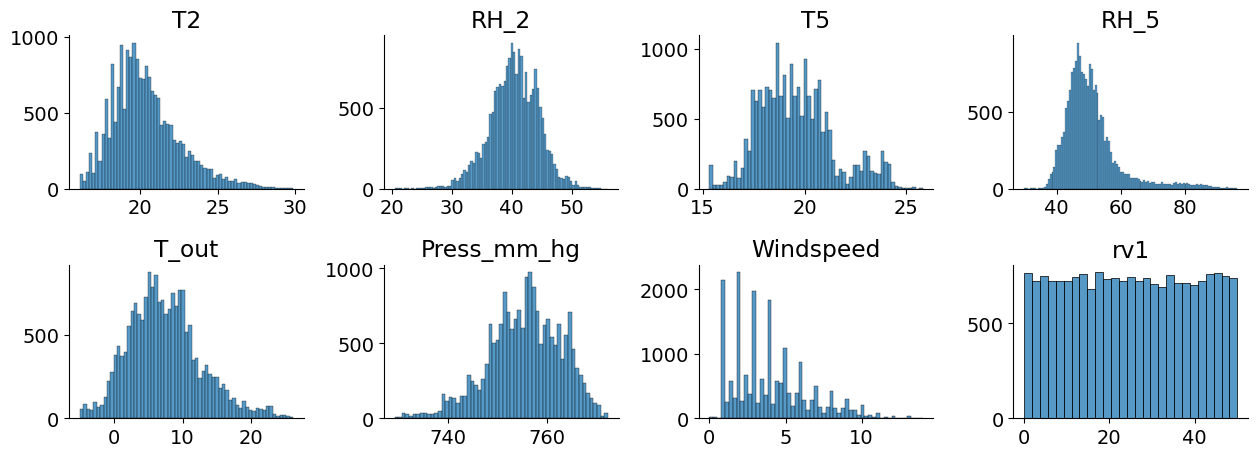

In [4]:
histplots_grid(2, 4, data, features = ["T2", "RH_2", "T5", "RH_5", "T_out", "Press_mm_hg", "Windspeed", "rv1"])

RH_6 contains information about the humidity outside the house, while RH_out provides data from the weather station. The distributions of these two variables can be seen below.

**The values in RH_6 are peculiar** and significantly differ from those obtained from the weather station, suggesting that a part of the measurement process might have gone wrong. For instance, there are many values at 0 and others less than 25%, which are improbable given the maritime temperate [climate of Belgium](https://en.wikipedia.org/wiki/Belgium#Geography) where such low humidity levels are virtually impossible. In contrast, the values in the RH_out variable appear more reasonable. Due to these discrepancies, **it was decided to exclude the RH_6 variable** and rely solely on the humidity information from RH_out.

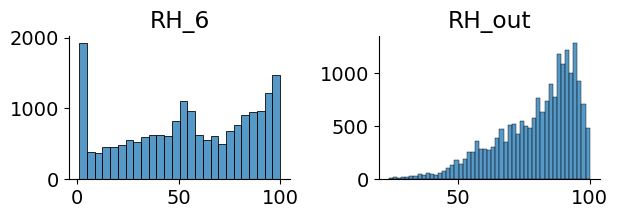

In [5]:
histplots_grid(1, 2, data, features = ["RH_6", "RH_out"])

## Energy consumption over the entire time period covered by the data

It was verified that the time differences in the data are always equal to 10 minutes.

In [6]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.min(), time_diffs.max()

(10.0, 10.0)

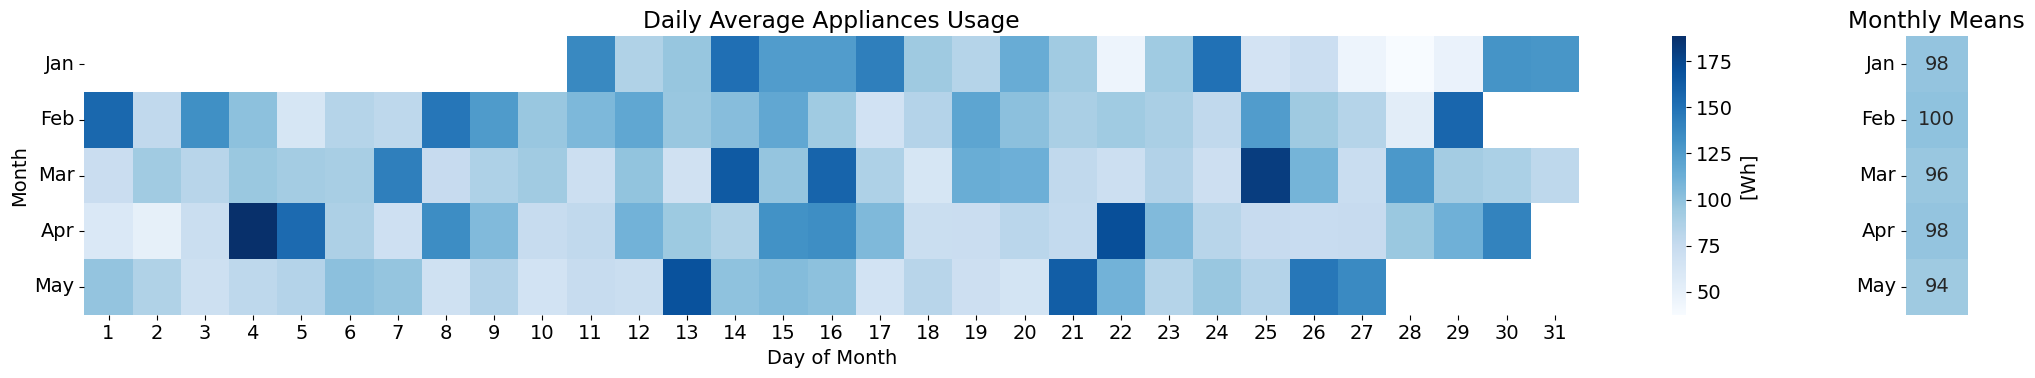

In [7]:
energy_consumption_all_time(data.Appliances)

**In the chart below**, it can be seen that light usage decreases over time, especially from around the end of March. This is associated with the days getting longer at the Belgium's latitude. Additionally, in Belgium, there is a time change at the end of March to save energy.\
It's noteworthy that the data does not reflect the clock change (a 1-hour advancement on the last Sunday of March); therefore, it is likely that a consistent time standard is used throughout the entire period covered by the data.

Another point to observe is that there are two periods (each 2-3 days long) where there is no light energy consumption and general consumption is minimal. It is assumed that during these days, the usual daily activities did not occur - probably because nobody was home.

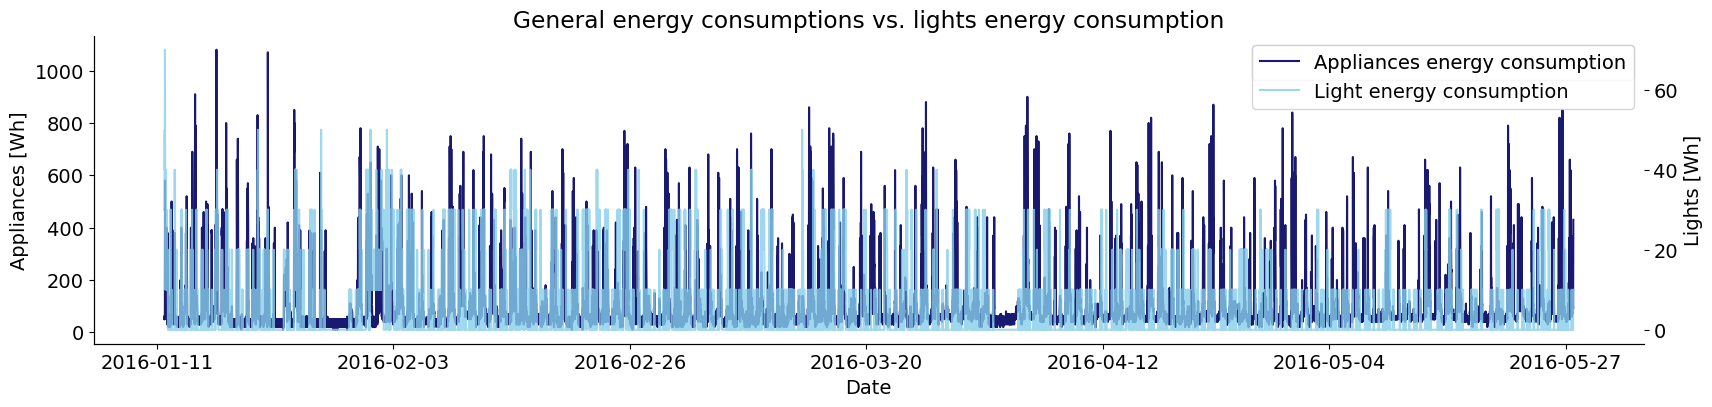

In [8]:
energy_vs_lights_plot(data.Appliances, data.lights)

The target variable might require a transformation due to its skewed distribution.

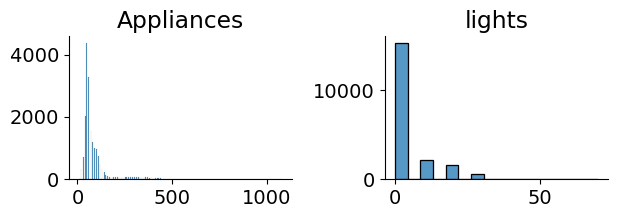

In [10]:
histplots_grid(1, 2, data, features = ["Appliances", "lights"])

## Energy consumption in smaller periods

At this stage, certain datetime features were added that can be helpful for further analysis and for the future use of machine learning algorithms.

Additionally, RH_6 variable was removed as explained above.

In [96]:
enhanced_data = add_datetime_features(data)
enhanced_data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)

enhanced_data.iloc[:,-8:].head(3)

,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,
2016-01-11 17:00:00,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,Monday,17,20,evening,2,11,0,0


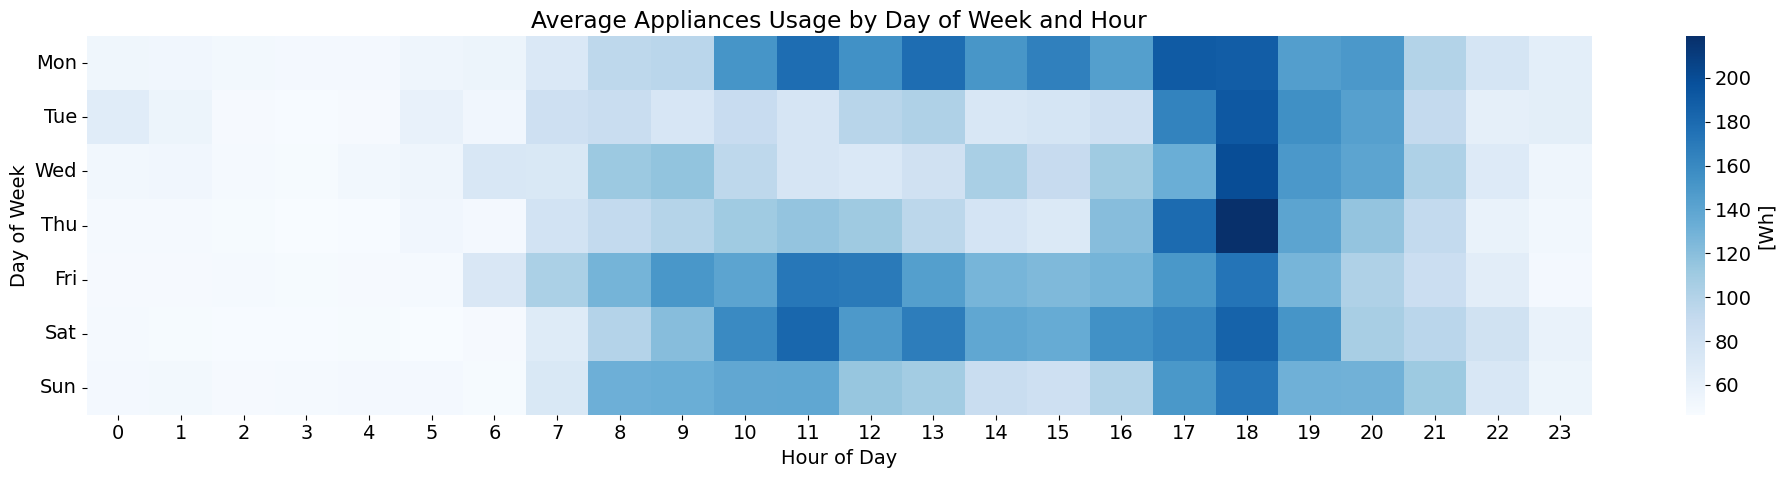

In [12]:
consumption_by_day_and_hour(enhanced_data[["Appliances", "day_of_week", "hour"]])

In [10]:
def plot_weekly_data(data, week, variables, figsize=(20, 10)):
    
    weekly_data = data[data['week_of_year'] == week]

    fig, axes = plt.subplots(len(variables), 1, figsize=figsize, sharex=True)

    for i, var in enumerate(variables):
        sns.lineplot(x=weekly_data.index, y=weekly_data[var], ax=axes[i])
        axes[i].set_title(f"{var} - Week {week}")
        axes[i].set_ylabel(var)
        axes[i].set_xlabel('')

    plt.tight_layout()
    plt.show()

In [222]:
# plot_weekly_data(enhanced_data, week=2, variables=['Appliances', 'lights', 'T1', 'RH_1'])

In [84]:
adfuller(data.Appliances)

(-21.61637819803621,
 0.0,
 11,
 19723,
 {'1%': -3.430681600227742,
  '5%': -2.8616865555329394,
  '10%': -2.566848007525354},
 220573.74967981718)

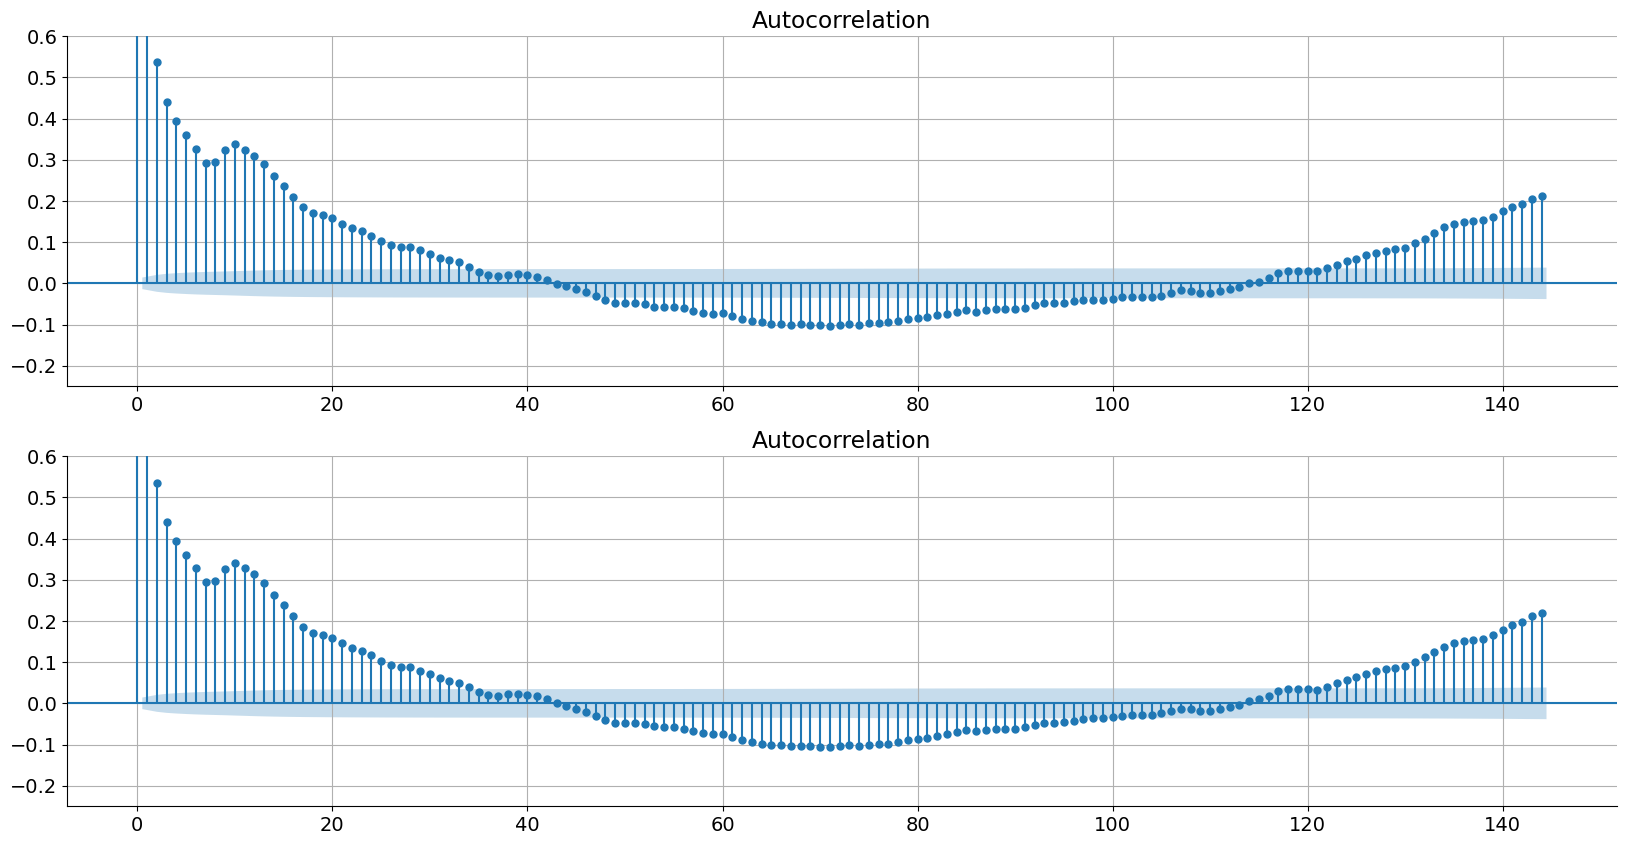

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sm.graphics.tsa.plot_acf(enhanced_data['Appliances'], ax=ax[0], lags=144)
sm.graphics.tsa.plot_acf(enhanced_data['Appliances_24'], ax=ax[1], lags=144)
for ax in [ax[0], ax[1]]:
    ax.grid(True)
    ax.set_ylim(-0.25, 0.6)
plt.show()

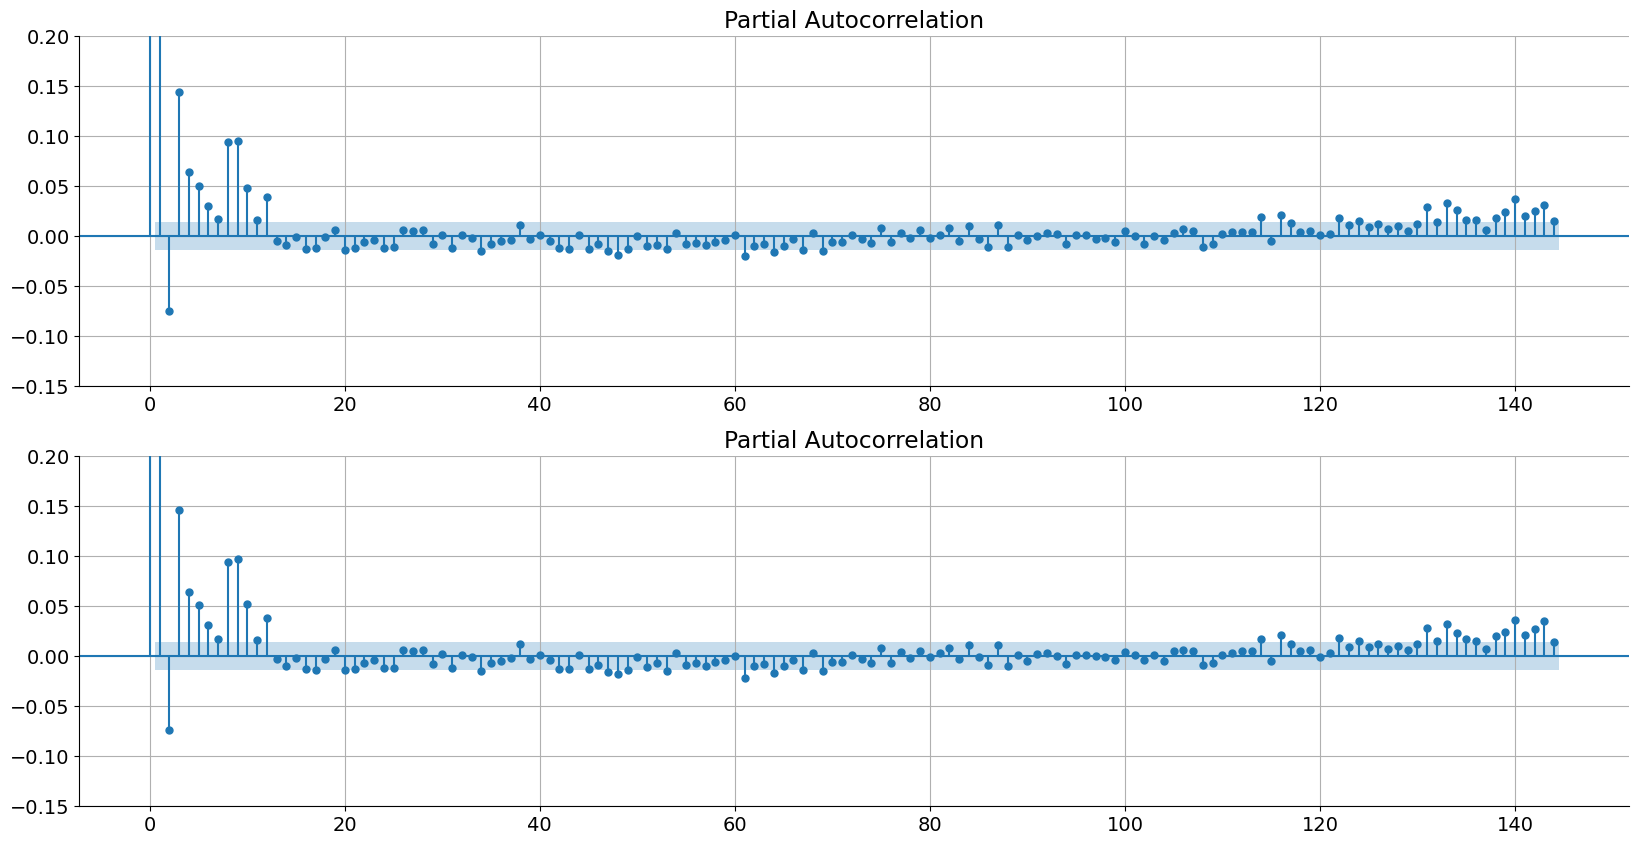

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sm.graphics.tsa.plot_pacf(enhanced_data['Appliances'], ax=ax[0], lags=144)
sm.graphics.tsa.plot_pacf(enhanced_data['Appliances_24'], ax=ax[1], lags=144)
for ax in [ax[0], ax[1]]:
    ax.grid(True)
    ax.set_ylim(-0.15, 0.2)
plt.show()

## Experiments

In [174]:
# days_to_remove = ['2016-01-27', '2016-01-28', '2016-01-29', '2016-04-01', '2016-04-02']
# days_to_remove = pd.to_datetime(days_to_remove)

# data = data[~data.index.normalize().isin(days_to_remove)]
# data

## Target +24h

In [189]:
enhanced_data = add_datetime_features(data)
enhanced_data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)

enhanced_data["Appliances_24"] = enhanced_data.Appliances.shift(-24*6)
enhanced_data.dropna(inplace=True)

enhanced_data = add_lagged_features(enhanced_data, "Appliances", lag=1, how_many=24*6-1)

In [190]:
enhanced_data.shape

(19448, 177)

In [191]:
enhanced_data.loc[:,["Appliances", "Appliances_24"]]

,Appliances,Appliances_24
date,,
2016-01-12 16:50:00,40,100.0
2016-01-12 17:00:00,60,90.0
2016-01-12 17:10:00,60,100.0
2016-01-12 17:20:00,210,90.0
2016-01-12 17:30:00,380,110.0
...,...,...
2016-05-26 17:20:00,600,100.0
2016-05-26 17:30:00,520,90.0
2016-05-26 17:40:00,290,270.0


In [192]:
X = enhanced_data.drop(["Appliances_24"], axis = 1)
y = enhanced_data.Appliances_24

In [193]:
n_test = 144*7
X_train, y_train = X.iloc[:-n_test], y.iloc[:-n_test]
X_test, y_test = X.iloc[-n_test:], y.iloc[-n_test:]

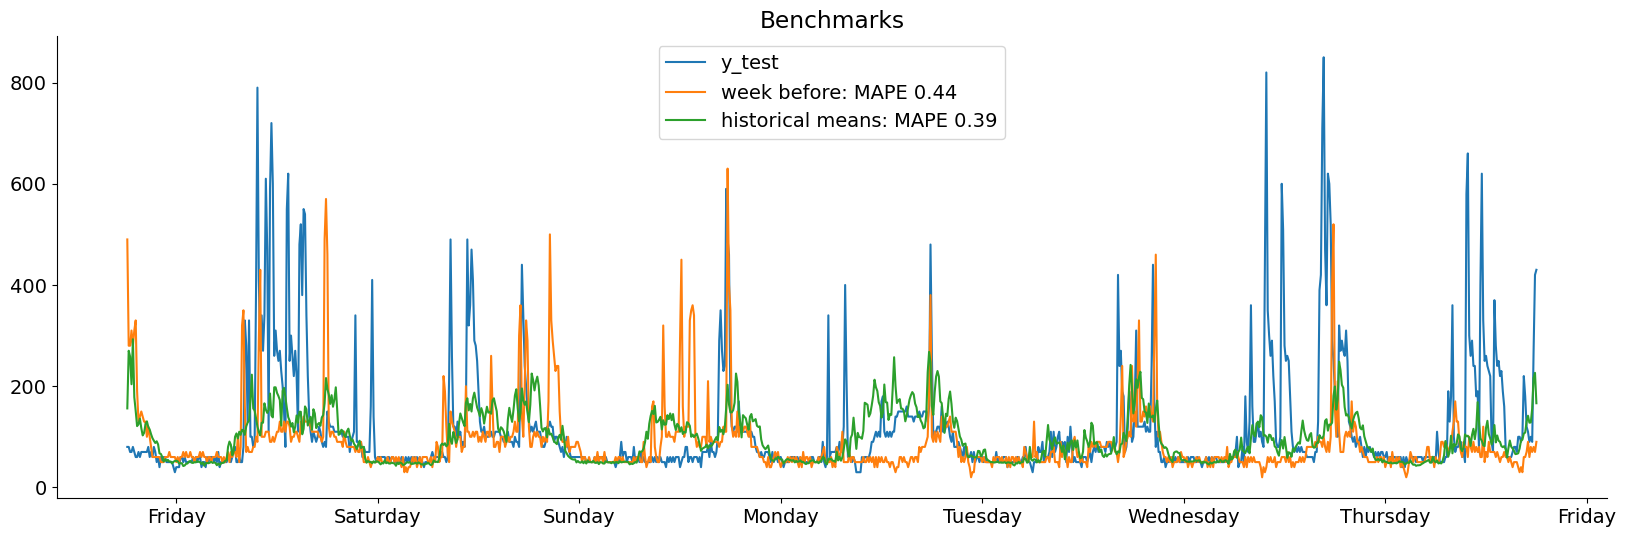

In [194]:
X_train_data = enhanced_data.iloc[:-n_test]

means = X_train_data.groupby(['day_of_week', 'hour', 'minute'])['Appliances'].mean()
historical_means = X_test.apply(lambda row:
                                means.loc[(row['day_of_week'], row['hour'], row['minute'])], 
                                axis=1)
day_before = enhanced_data.Appliances.iloc[-n_test:]
week_before = enhanced_data.Appliances_24.shift(1008).iloc[-n_test:]

plt.figure(figsize=(20,6))
plt.plot(X_test.index, y_test, label='y_test')
plt.plot(X_test.index, week_before, 
         label=f'week before: MAPE {mean_absolute_percentage_error(y_test, week_before).round(2)}')
plt.plot(X_test.index, historical_means, 
         label=f'historical means: MAPE {mean_absolute_percentage_error(y_test, historical_means).round(2)}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))
plt.legend()
plt.title("Benchmarks")
plt.show()

In [217]:
def diagnose_errors(y_test, y_pred):

    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    
    ax[0].scatter(y_test, y_pred)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="r" )
    ax[0].set_title("y_pred ~ y_test")
    
    errors = y_test - y_pred
    ax[1].scatter(range(len(errors)), errors)
    ax[1].hlines(0, 1000, 0, color="r")
    ax[1].set_title("res ~ i")
    
    ax[2].scatter(y_test, errors)
    ax[2].hlines(0, 1000, 0, color="r")
    ax[2].set_title("res ~ y_test")
    
    ax[3].hist(errors)
    ax[3].set_title("errors")

    plt.tight_layout()
    plt.show()

def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mean_absolute_percentage_error(y_test, y_pred)
    
    plt.figure(figsize=(20,6))
    plt.plot(X_test.index, y_test)
    plt.plot(X_test.index, y_pred,
            color="red", label=f"model prediction: MAPE {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))
    plt.legend()
    plt.show()
    print("\n\n")
    diagnose_errors(y_test, y_pred)

In [205]:
lagged_features = [feature for feature in X_train.columns if feature.startswith("lag")]
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
preprocessor = make_column_transformer((OneHotEncoder(), ["day_of_week", "time_of_day"]),
                                                 (log_transformer, lagged_features),
                                                 remainder="passthrough")

In [206]:
XGBoost = XGBRegressor(min_child_weight=100, reg_lambda=10, eta=0.04, colsample_bytree=0.3)

pipe = make_pipeline(preprocessor, XGBoost)
model = TransformedTargetRegressor(pipe, transformer=log_transformer)

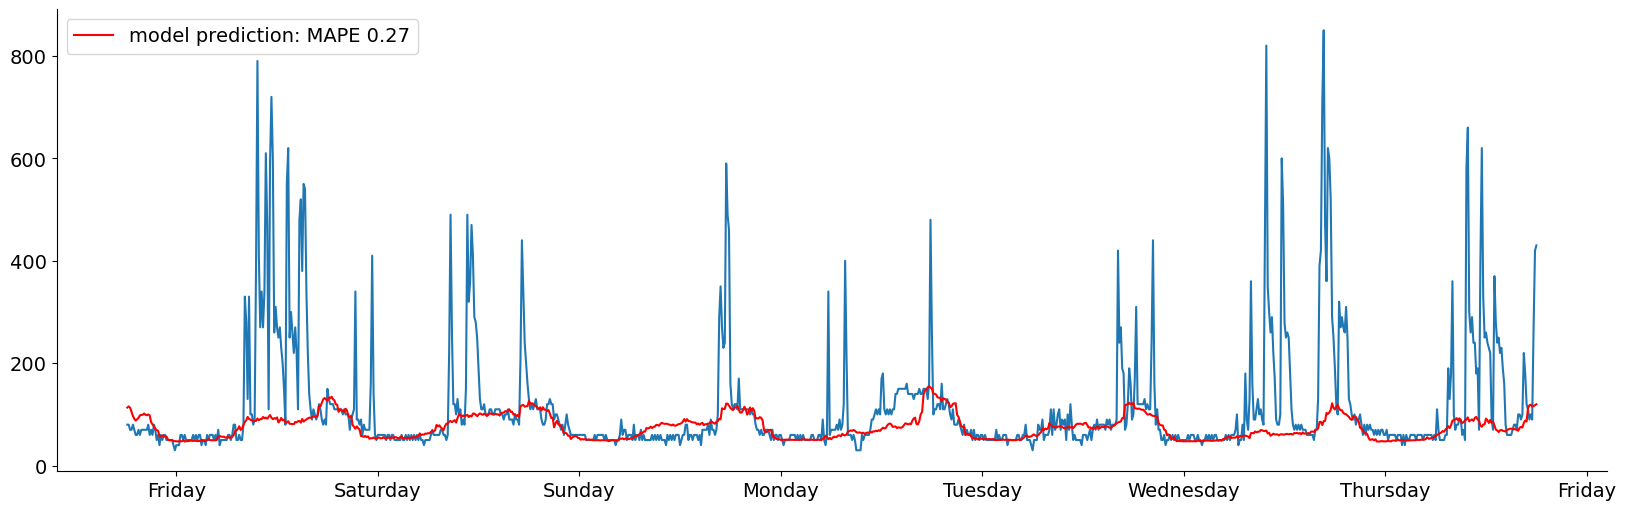

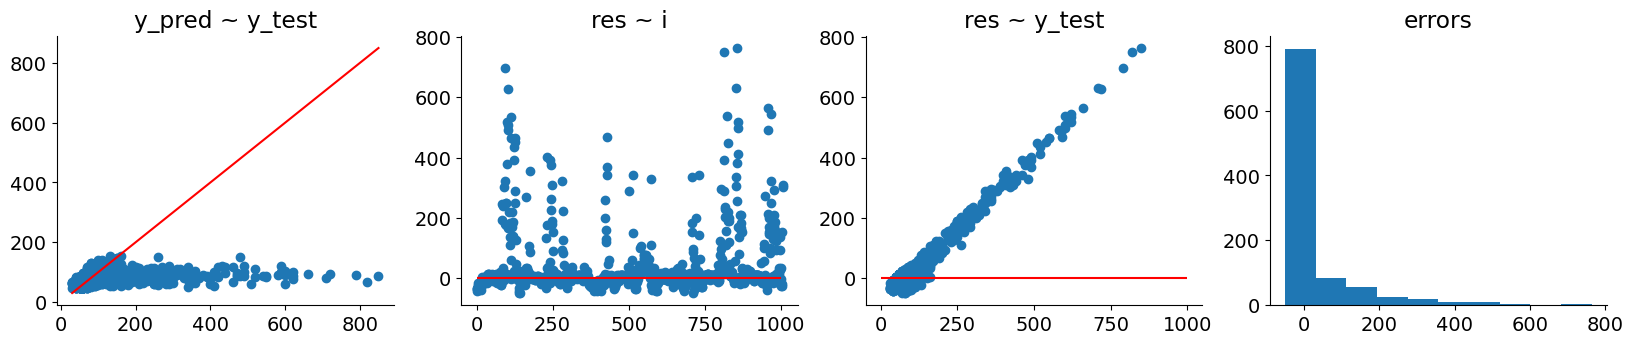

In [211]:
evaluate_model(X_train, X_test, y_train, y_test, model)

### Adding a column to mark high values because the model greatly underestimates them, regardless of the day, the larger the true value, the larger the error.

In [212]:
X = enhanced_data.drop(["Appliances_24"], axis = 1)
y = enhanced_data.Appliances_24
X["large_values"] = np.where(y > np.quantile(y, 0.9), 1, 0)

n_test = 144*7
X_train, y_train = X.iloc[:-n_test], y.iloc[:-n_test]
X_test, y_test = X.iloc[-n_test:], y.iloc[-n_test:]

/tmp/ipykernel_7618/2279038024.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["large_values"] = np.where(y > np.quantile(y, 0.9), 1, 0)


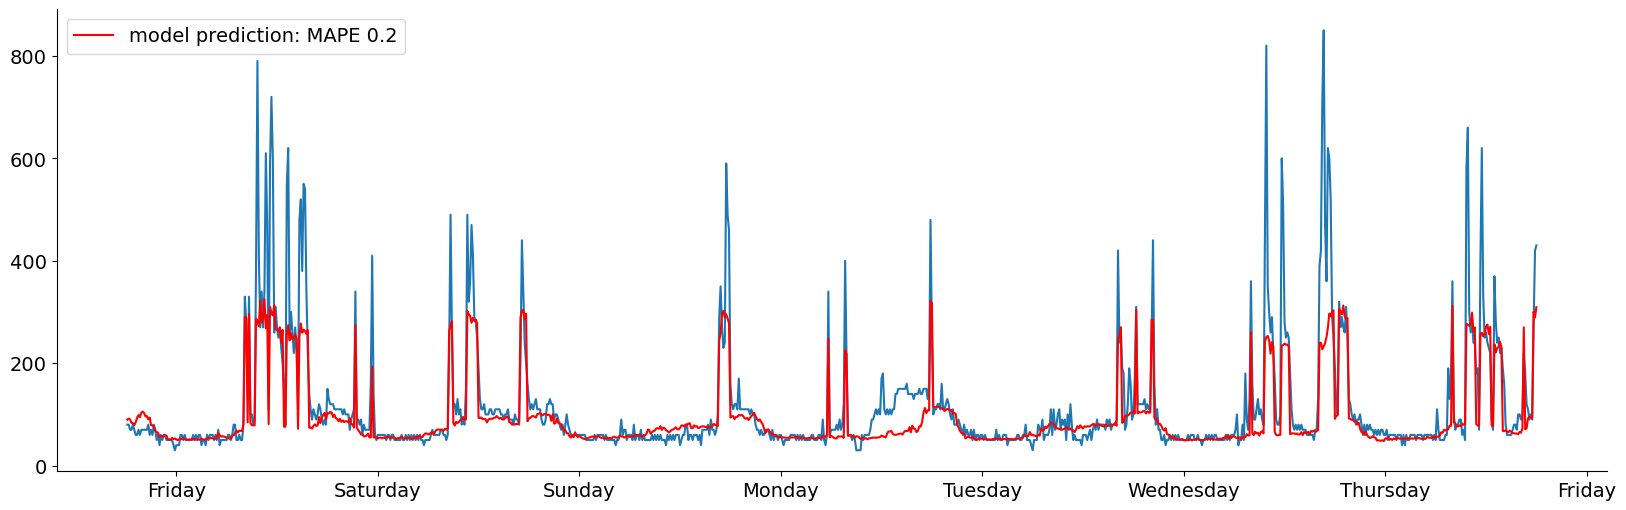

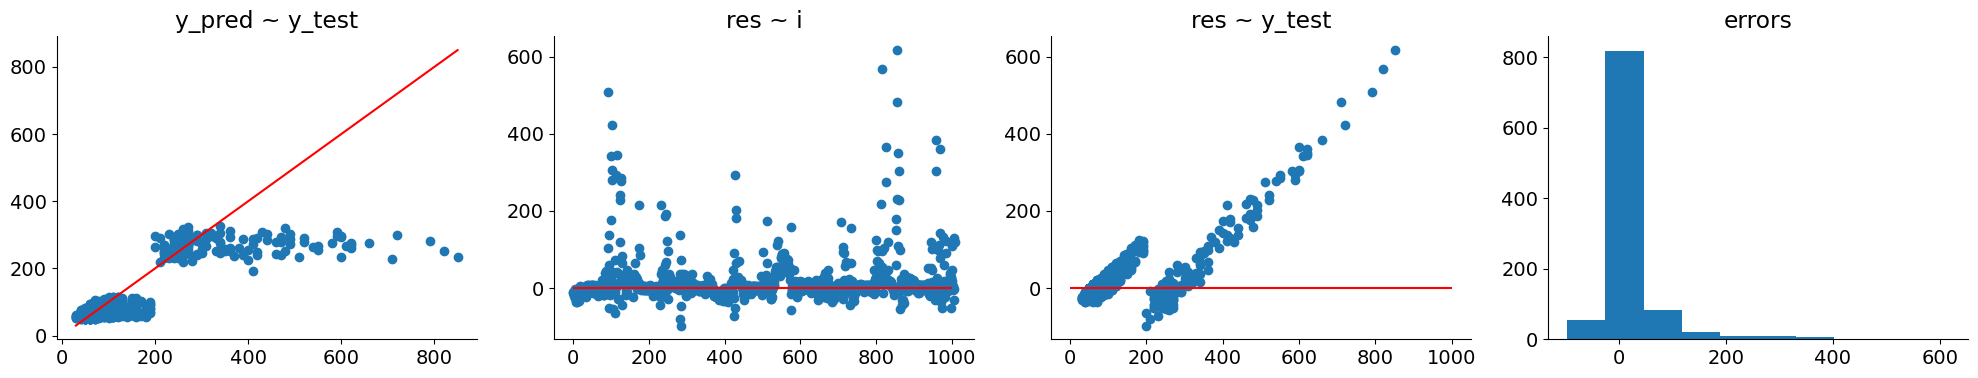

In [221]:
XGBoost = XGBRegressor(min_child_weight=100, reg_lambda=10, eta=0.1, colsample_bytree=0.3, max_delta_step=3.5)

evaluate_model(X_train, X_test, y_train, y_test, model)

In [219]:
all_results = {}
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
preprocessor = make_column_transformer((OneHotEncoder(), ["day_of_week", "time_of_day"]),
                                                 (log_transformer, lagged_features),
                                                 remainder="passthrough")

for model in [Ridge(alpha=0.1), 
              Lasso(alpha=0.1), 
              SVR(C=0.1, epsilon=0.2),
              ExtraTreesRegressor(min_samples_leaf=50, max_features=0.3), 
              RandomForestRegressor(min_samples_leaf=50, max_features=0.3), 
              BaggingRegressor(n_estimators=100, max_features=0.3), 
              HistGradientBoostingRegressor(min_samples_leaf=50, l2_regularization=0.1),
              XGBRegressor(min_child_weight=100, reg_lambda=10, eta=0.1, colsample_bytree=0.3)]:

    model_name = model.__class__.__name__
    pipe = make_pipeline(preprocessor, model)

    results = {}
    model = TransformedTargetRegressor(pipe, transformer=log_transformer)
    model.fit(X_train, y_train)
    y_fitted = model.predict(X_train)
    y_pred = model.predict(X_test)

    err_fitted = mean_absolute_percentage_error(y_train, y_fitted)
    mse_fitted = mean_squared_error(y_train, y_fitted)
    err_pred = mean_absolute_percentage_error(y_test, y_pred)
    mse_pred = mean_squared_error(y_test, y_pred)

    results["mape_fitted"] = err_fitted
    results["mse_fitted"] = mse_fitted
    results["mape_pred"] = err_pred
    results["mse_pred"] = mse_pred
    
    all_results[model_name] = results
    
df = pd.DataFrame.from_dict(all_results, 
                            orient = "index", 
                            columns = ["mape_fitted", "mse_fitted", "mape_pred", "mse_pred"])

In [220]:
df

,mape_fitted,mse_fitted,mape_pred,mse_pred
Ridge,0.273465,2747.503819,0.231985,3769.125502
Lasso,0.375404,8109.219474,0.285870,10510.591996
SVR,0.364083,10474.860364,0.296540,13710.238463
ExtraTreesRegressor,0.227388,2316.155299,0.202613,3829.752679
RandomForestRegressor,0.217560,2353.971063,0.206990,3970.279810
BaggingRegressor,0.085922,1085.631021,0.266220,9408.671054
HistGradientBoostingRegressor,0.183852,1666.777060,0.210277,3533.242082
XGBRegressor,0.203000,1961.365196,0.203297,4516.440671
